# Example use of the pyf3d python package 

In [31]:
import os
import copy
import uuid
import datetime
import numpy as np
import pandas as pd
from pyf3d import TimeUTC, Grid, MeteoData, Source, Fall3DInputFile, CARRASource, Fall3DBatch

## Single run created from scratch

In [24]:
# We can create a Fall3D run from scratch by initialising the sections
# manually and putting them together into a Fall3DInputFile object like 
# this:

grid = Grid(
    horizontal_mapping = "SPHERICAL", 
    vertical_mapping = "SIGMA_LINEAR_DECAY", 
    lonmin = -23.0, 
    lonmax = -21.5, 
    latmin = 63.7, 
    latmax = 64.2, 
    nx = 50, 
    ny = 50, 
    nz = 10,
    zmax = 2500
)

meteo_data = MeteoData(
    meteo_data_format = "CARRA", 
    meteo_data_dictionary_file = "/RUNS/CARRA.tbl", 
    meteo_data_file = "mnt/examples/test_meteo.nc", 
    meteo_ensemble_basepath = "./", 
    meteo_levels_file = "../Other/Meteo/Tables/L137_ECMWF.levels", 
    dbs_begin_meteo_data = 0, 
    dbs_end_meteo_data = 120, 
    meteo_coupling_interval = 60, 
    memory_chunk_size = 3
)

# and the same for time_utc, insertion_data, etc. We would then initialise 
# the file object with:
#
#file = Fall3DInputFile(,
#                time_utc,
#                insertion_data,
#                meteo_data,
#                grid,
#                species,
#                tephra_tgsd,
#                radionucleides_tgsd,
#                particle_aggregation,
#                source,
#                ensemble,
#                emsemble_postprocess,
#                model_physics,
#                model_output,
#                model_validation,
#                )
#
# However we won't bother doing that here - instead we'll load an existing 
# file and modify it.
#


WARNING sigma_values_currently_disabled


## Single run from modified file

In [25]:
# Alternatively, we can load an exisiting file, inspect it, and modify it
# to suit our purposes.
# we load the example  Fall3D file into memory as an object
file = Fall3DInputFile.from_file("mnt/examples/default_so2_reykjanes.inp")

WARNING sigma_values_currently_disabled


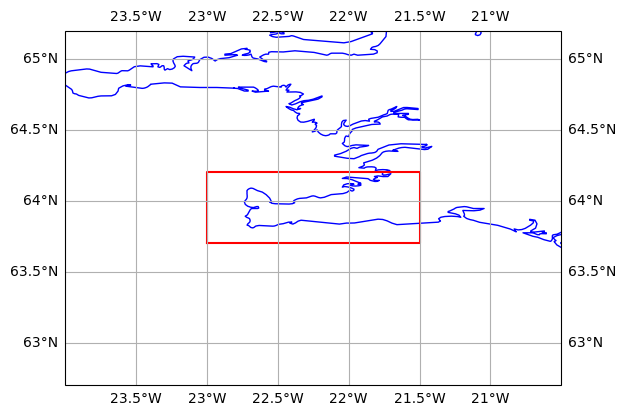

In [26]:
# Each separate section of a Fall3D input file is represented as a different
# attribute of the file object, combined with some helper functions for 
# displaying and fetching data. The area that we want model is specified in 
# the "grid" section, which provides a function to plot the area on a map.

file.grid.plot_on_map()

In [27]:
# we can e.g. extend the area to the north using the update function, which
# takes a dict of dicts formatted like this:
#
# {'section':{'attribute':value}}
#
# this is useful if we want to update many sections at once when doing a batch run

file.update({'grid':{'latmax':64.5}})

# alternatively, we can update the section specifically

file.grid.update({'latmax':64.5})

# using the update function re-initialises the object, making sure all type and value 
# checks are performed again.

WARNING sigma_values_currently_disabled
WARNING sigma_values_currently_disabled


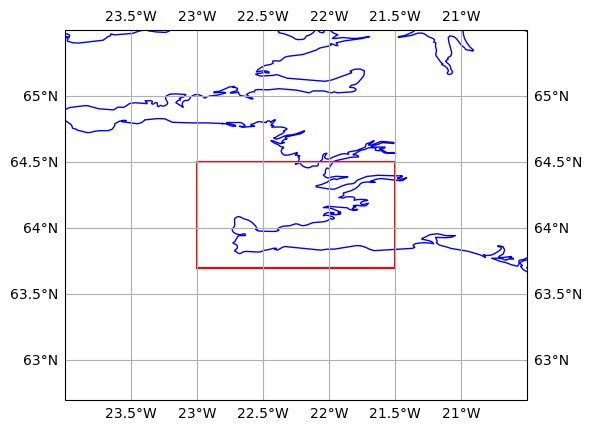

In [28]:
# we plot the updated file to check it has been updated
file.grid.plot_on_map()

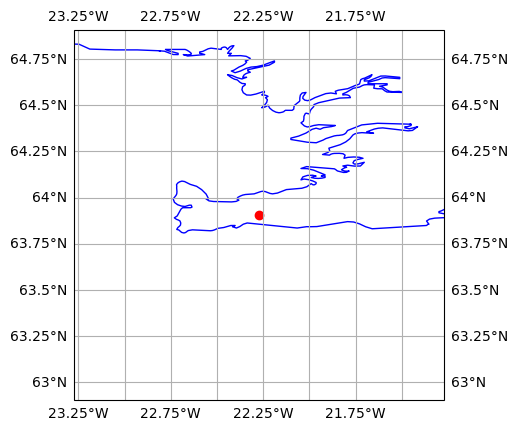

In [6]:
# we can also inspect the source, which we will leave as it is
file.source.plot_on_map()

In [12]:
# now we look at the meteo data
# evaluating a section prints it as it would appear in a Fall3D input file
file.meteo_data

 ----------
 METEO_DATA
 ----------
   !
   !    METEO_DATA_FORMAT             options : WRF/ GFS / ERA5 / ERA5ML / IFS / CARRA
   !    METEO_DATA_DICTIONARY_FILE            : Optional. Path to the meteo model dictionary file. If not given, dafault value is used.
   !    METEO_DATA_FILE                       : path to the meteo model data file
   !    METEO_ENSEMBLE_BASEPATH               : Root path for METEO_DATA_FILE. Used for ensemble runs when multiple meteo files are available ($METEO_ENSEMBLE_BASEPATH/0001/$METEO_DATA_FILE...). If not provided a single meteo file is used for the ensemble (METEO_DATA_FILE)
   !    METEO_LEVELS_FILE                     : path to the meteo model levels file. Only used if METEO_DATA_FORMAT = ERA5ML or IFS
   !    DBS_BEGIN_METEO_DATA_(HOURS_AFTER_00) : value.
   !    DBS_END_METEO_DATA_(HOURS_AFTER_00)   : value.
   !    METEO_COUPLING_INTERVAL_(MIN)         : value. Time interval update of meteorological variables (does not apply to velocity)
   ! 

In [30]:
# we see that we have selected the CARRA reanylsis. We need to do two things
# (1) set values of METEO_DATA_DICTIONARY_FILE, METEO_LEVELS_FILE to match your 
#     fall3d install (thios is handled automatically by the script in the docver container
# (2) get the metdata

In [ ]:
file.meteo_data.update({
    'METEO_DATA_DICTIONARY_FILE':'/home/talfan/Software/Fall3D/RUNS/CARRA.tbl',
    'METEO_LEVELS_FILE':"/home/talfan/Software/Fall3D/RUNS/L137_ECMWF.levels"
})

In [ ]:
# The function get_meteodata will
# automatically get the spatial and temporal extent needed, check local storage for 
# the needed data, and order it if it missing, saving it to the path speciifed in
# the meteo_data object
file.get_meteodata()

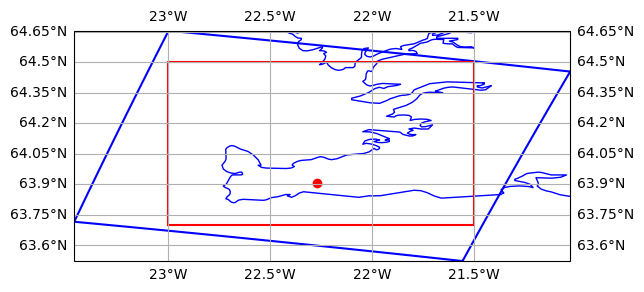

In [8]:
# now that we have the CARRA data, we can plot
#  (1) extent of our desire analysis (specified by file.grid)
#  (2) extent of the CARRA data (automatically calculated and ordered by file.meteo_data.get_meteodata)
#  (3) the source location
file.plot_on_map()

In [ ]:
# now we run Fal3D on the file
# we always need to specify an output file 
file.run()

## Batch run

In [32]:
# we load a default SO2 input file
f3if = Fall3DInputFile.from_file("mnt/examples/default_so2_reykjanes.inp")

# initialise random number generator
seed = 12345
rng = np.random.default_rng(seed)

# decide how many training samples we want
size= 100

# Get random starting dates ...
start_date = datetime.datetime(year=1991,month=1,day=1)

end_date = datetime.datetime(year=2022,month=1,day=1)

# ... by getting the interval between the start and end in hours ...
interval_in_hours = (end_date - start_date).days * 24

# ... generating random integers between 0 and the interval in hours ...
random_hours = rng.integers( low=0, high=interval_in_hours, size=size)

# ... and adding that random integer in hours to the starting date ...
random_dates  = [start_date + datetime.timedelta(hours=int(h)) for h in random_hours]

# ... we then extract the year, month, and day and hours (run_starts) from this list of dates
years = [d.year for d in random_dates]
months = [d.month for d in random_dates]
days = [d.day for d in random_dates]
run_starts = [d.hour for d in random_dates]

# We also get random plume heights uniformly distributed between a minimum and maximum ...
min_height_above_vent = 500.0
max_height_above_vent = 5000.0
height_above_vents = rng.uniform(
                                size=size, 
                                low = min_height_above_vent, 
                                high = max_height_above_vent
                            )


# and the same for random gas fluxes
min_mass_flow_rate = 0.0
max_mass_flow_rate = 500.0
mass_flow_rates = rng.uniform(
                                size=size,
                                low = min_mass_flow_rate,
                                high = max_mass_flow_rate
                            )

#  last, we need a random identifier for each run, which is used for 
# the name of the directory, input file and meteo file
uids = [str(uuid.uuid4()) for i in range(size)]

meteo_data_files = [os.path.join("mnt","runs",u,u+"_meteo.nc") for u in uids]

# Finally we put it all into a dataframe for input into Fall3DBatch
# columns need to have name section.attribute and the index value
# is used for the folder name, input file name and input meteofile name

df = pd.DataFrame({
        'time_utc.year':years,
        'time_utc.month':months,
        'time_utc.day':days,
        'time_utc.run_start':run_starts,
        'source.height_above_vent':height_above_vents,
        'source.mass_flow_rate':mass_flow_rates,
        'meteo_data.meteo_data_file':meteo_data_files
    },index=uids)

df

WARNING sigma_values_currently_disabled


,time_utc.year,time_utc.month,time_utc.day,time_utc.run_start,source.height_above_vent,source.mass_flow_rate,meteo_data.meteo_data_file
99429e98-807f-45d9-86f2-fbdd4b280d47,2012,9,4,5,1770.722183,388.006539,mnt/runs/99429e98-807f-45d9-86f2-fbdd4b280d47/...
8d24eb2b-6e2c-4b03-8475-658f557a72b3,1998,1,18,3,806.394603,434.135431,mnt/runs/8d24eb2b-6e2c-4b03-8475-658f557a72b3/...
5402a2d5-6f6a-41f1-8f79-a4e6fa0cc66f,2015,6,13,20,3275.730398,238.579126,mnt/runs/5402a2d5-6f6a-41f1-8f79-a4e6fa0cc66f/...
a4a9473c-1e2e-46e9-bba7-586a65bfb473,2000,10,26,15,1293.468441,84.424320,mnt/runs/a4a9473c-1e2e-46e9-bba7-586a65bfb473/...
245db8bc-50dc-4159-9003-b3c4e28fba46,1997,4,30,21,1869.747742,266.988661,mnt/runs/245db8bc-50dc-4159-9003-b3c4e28fba46/...
...,...,...,...,...,...,...,...
0316016a-8f24-4f76-b4f9-08d4cac19670,2002,1,7,17,750.211596,94.993874,mnt/runs/0316016a-8f24-4f76-b4f9-08d4cac19670/...
c30f8faf-60ba-4dfb-b77a-83d2c801bd03,1993,1,2,8,3932.927015,106.766593,mnt/runs/c30f8faf-60ba-4dfb-b77a-83d2c801bd03/...
fadefcec-9ea1-4f23-ab1e-bd7cbc97d3f4,1991,2,26,20,506.834545,431.514856,mnt/runs/fadefcec-9ea1-4f23-ab1e-bd7cbc97d3f4/...
79886ee6-22fc-441a-b6d7-e3292207756b,1991,10,12,7,917.795927,166.961966,mnt/runs/79886ee6-22fc-441a-b6d7-e3292207756b/...


In [ ]:
 
# we need a name for this batch run - this will be used to name
# the directory in which thre directories for each run will be stored
# and also the name of .csv file df is saved to
name = "test"

# ... we then initialise the object ...
batch = Fall3DBatch(name=name, basefile=f3if, df=df, basedir="mnt/runs")

# ... initialise the batch - creates the diurectories and input files ...
batch.initialise()

# ... iterates over the input files and gets the appropriate met data ....
batch.get_meteo_data()

# ... iterates over every input file and runs Fall3D
batch.run()

 